In [2]:
import heapq
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem 
from collections import Counter
from collections import defaultdict 
from sklearn.metrics import roc_auc_score

In [3]:
df_raw = pd.read_csv('../dataset/tox21/raw/tox21.csv')
df_raw.rename(columns={'smiles': 'COMPOUND_SMILES'}, inplace=True)
df = pd.read_csv('../analysis/random_split.csv')
# df = pd.read_csv('/gxr/xinze/admet/MGSSL/finetune/dataset/tox21/raw/tox21_split.csv')
df_merge = pd.merge(df, df_raw, on='COMPOUND_SMILES', how='inner')
smiles_train = df_merge[df_merge.SPLIT=='train'].COMPOUND_SMILES.values
smiles_valid = df_merge[df_merge.SPLIT=='valid'].COMPOUND_SMILES.values
smiles = df_merge.COMPOUND_SMILES.values
fplist = [] #fplist
for smi in tqdm(smiles_train):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fplist.append(fp)
props = ['NR-AR', 'NR-AR-LBD', 'NR-AhR',
       'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE',
       'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

  0%|          | 0/6264 [00:00<?, ?it/s]RDKit WARNING: [17:14:39] WARNING: not removing hydrogen atom without neighbors
[17:14:39] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 6264/6264 [00:01<00:00, 5918.81it/s]


In [4]:
def get_top_k(fplist, smi, k):
    mol = Chem.MolFromSmiles(smi)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity_matrix = []
    for fp2 in fplist:
        simlarity = DataStructs.DiceSimilarity(fp1, fp2)
        similarity_matrix.append(simlarity)
    res = heapq.nlargest(k, range(len(similarity_matrix)), similarity_matrix.__getitem__)
    return res

In [6]:
mode = 'random'
res = np.load(f'../analysis/tox21_{mode}_pred.npy')
test_idices = np.load(f'../analysis/tox21_{mode}_test_indices.npy')
smiles_test = df_merge.loc[test_idices].COMPOUND_SMILES.values

auc_list = {}
for idx, prop in enumerate(props):
    y_true = df_merge.loc[test_idices][prop]
    y_true = y_true.replace(0, -1)
    y_true = y_true.fillna(0)
    y_score = res[:, idx]
    is_valid = y_true ** 2 > 0
    auc = roc_auc_score((y_true[is_valid] + 1)/2, y_score[is_valid])
    auc_list[prop] = auc

print(auc_list)
np.mean(list(auc_list.values()))

{'NR-AR': 0.75971125648545, 'NR-AR-LBD': 0.8767407407407408, 'NR-AhR': 0.9012737399561724, 'NR-Aromatase': 0.8557619884509164, 'NR-ER': 0.7603666789713303, 'NR-ER-LBD': 0.8093979326126409, 'NR-PPAR-gamma': 0.8708381683477641, 'SR-ARE': 0.8125212521252125, 'SR-ATAD5': 0.8947033358798064, 'SR-HSE': 0.780658754729962, 'SR-MMP': 0.8975499677627338, 'SR-p53': 0.8559749620637329}


0.8396248981772053

In [7]:
prop_idx = 0
y_true = df_merge.loc[test_idices][props[prop_idx]]
y_true = y_true.replace(0, -1)
y_true = y_true.fillna(0)
res = np.load(f'../analysis/tox21_{mode}_pred.npy')
y_score = res[:, prop_idx]
print(y_score[454])
y_score[454] = 1
# y_score[50] = 10
is_valid = y_true ** 2 > 0
auc = roc_auc_score((y_true[is_valid] + 1)/2, y_score[is_valid])
auc

-2.6159568


0.7613354387547937

In [10]:
error_smiles = defaultdict(list)
def get_hard_smiles(prop_idx, test_idices, res):
    y_true = df_merge.loc[test_idices][props[prop_idx]]
    y_true = y_true.replace(0, -1)
    y_true = y_true.fillna(0)
    y_score = res[:, prop_idx]

    pos_absolute_idices = y_true[y_true == 1].index
    
    pos_relative_idices = [np.argwhere(test_idices == x).item() for x in pos_absolute_idices]
    _, indices = torch.sort(torch.Tensor(y_score), descending=True)
    indices = indices.numpy()

    score_indices = []
    for idx in pos_relative_idices:
        score_indices.append(np.where(indices == idx)[0][0])
    score_indices = np.array(score_indices)

    smiles_list = []
    for i in sorted(score_indices)[::-1]:
        if i > len(pos_absolute_idices):
            idx = pos_absolute_idices[np.where(score_indices==i)[0][0]]
            
            smiles = df_merge.iloc[idx].COMPOUND_SMILES
            smiles_list.append(smiles)
    return smiles_list

for i in range(0, len(props)):
    error_smiles[props[i]].extend(get_hard_smiles(i, test_idices, res))

def check_smiles(smi, error_smiles=error_smiles):
    for idx, prop in enumerate(error_smiles):
        if smi in error_smiles[prop]:
            print(prop, idx)

In [11]:
smiles_list = get_hard_smiles(0, test_idices, res)
print(len(smiles_list))

17


NR-AR 0
(array([69]),)


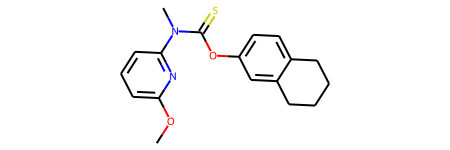

In [12]:
smi_idx = 14
check_smiles(smiles_list[smi_idx])
print(np.where(smiles_test==smiles_list[smi_idx]))
Chem.MolFromSmiles(smiles_list[smi_idx])

In [13]:
df_merge[df_merge.COMPOUND_SMILES == smiles_list[smi_idx]][props]

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
2350,1.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,0.0


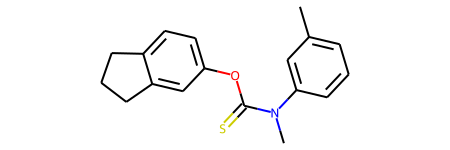

0 [0.0]


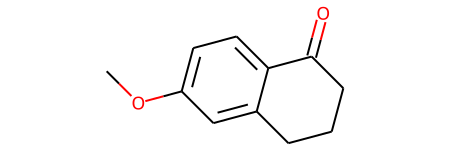

1 [nan]


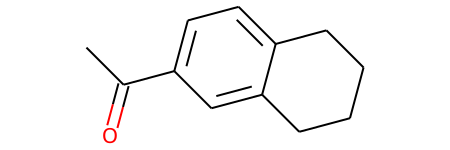

2 [0.0]


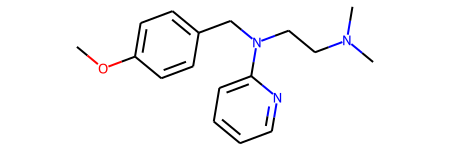

3 [0.0]


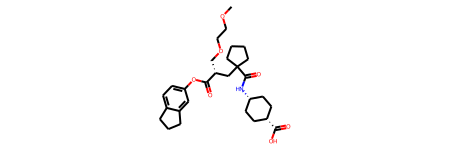

4 [0.0]


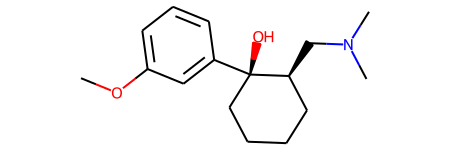

5 [0.0]


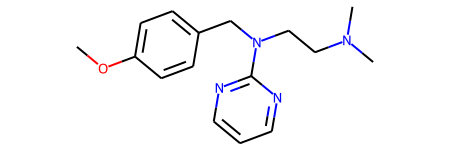

6 [0.0]


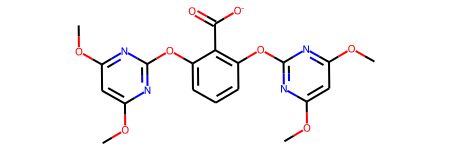

7 [0.0]


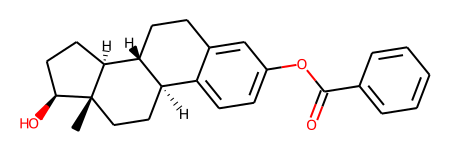

12 [1]


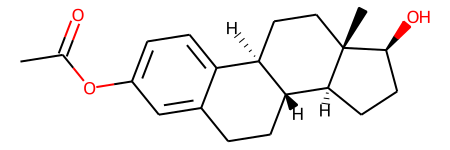

13 [1]


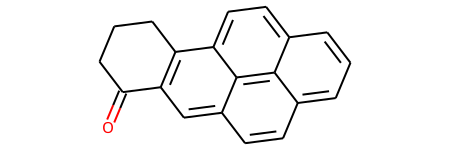

145 [1]


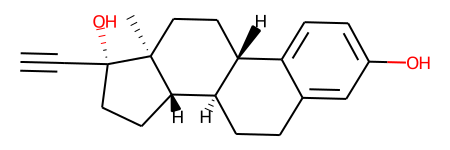

227 [1]


In [14]:
prop_idx = 1
indices = get_top_k(fplist, smiles_list[smi_idx], k=1000)
hit = 0
for order, idx in enumerate(indices):
    smi = smiles_train[idx]
    mol = Chem.MolFromSmiles(smi)
    
    label = df_merge[df_merge.COMPOUND_SMILES == smi][props[prop_idx]].item()
    if hit < 8:
        hit += 1
        display(mol)
        print(order, f'[{label}]')
    if hit >= 8:
        if label == 1:
            hit += 1
            display(mol)
            print(order, '[1]')
            if hit == 12:
                break

In [ ]:
a = 'COc1ccccc1N1CCN(CCCC(=O)c2ccc(F)cc2)CC1'
patt = Chem.MolFromSmarts('N1CCNCC1')
count = 0
labels = []
for smi in tqdm(smiles_train):
    mol = Chem.MolFromSmiles(smi)
    hit_ats = list(mol.GetSubstructMatch(patt))
    if hit_ats:
        label = df_merge[df_merge.COMPOUND_SMILES == smi][props[prop_idx]].item()
        if str(label) == 'nan': label = -1
        labels.append(label)
        count += 1
count
Counter(labels)

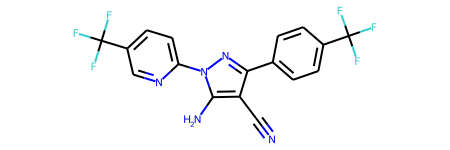

In [9]:
Chem.MolFromSmiles('N#Cc1c(-c2ccc(C(F)(F)F)cc2)nn(-c2ccc(C(F)(F)F)cn2)c1N')

In [ ]:
labels = []
for smi in tqdm(smiles_test):
    label = df_merge[df_merge.COMPOUND_SMILES == smi][props].fillna(-1)
    label = set(label.values[0])
    if 0 in label and 1 not in label:
        value = 1
    elif 1 in label and 0 not in label:
        value = 1
    else:
        value = 2
    labels.append(value)
Counter(labels)